Directory three of the project:

```
├── code
├── data
├── jmxs
├── model
├── pcaps
└── results
```

The working dir of the script is the code/ directory

The code will be used to extract data to instrument the model. The data has been obtained from the system executing the application. The perform N readings in a observation time interval T. 

    1. read data from the data dir/ - 
    
    ```
    ├── 10-38
    │   ├── containers_pre.json
    │   ├── containers_post.json
    │   ├── energy.csv
    │   ├── system_pre.json
    │   ├── system_post.json
    │   └── requests.jtl
    ├── 11-38
    │   ├── containers_pre.json
    │   ├── containers_post.json
    │   ├── energy.csv
    │   ├── system_pre.json
    │   ├── system_post.json
    │   └── requests.jtl
    ```
       
    The name of the directory contains two numbers. The former describes the ith reading while the second one the population of customers operating while reading performance and energy values.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from itertools import chain
import csv, json, glob, os
import matplotlib.pyplot as plt

### Requests Tree

In [2]:
CONVERSATIONS = pd.read_csv("experiment_configuration_data/conversations_names.csv")

In [3]:
def filter_requests(name):
    return CONVERSATIONS[(CONVERSATIONS == name).any(axis=1)]

In [4]:
filter_requests('ui')

,source,destination
1,145.108.225.16,ui
2,ui,auth
4,ui,verification-code
5,ui,travel
18,ui,assurance
19,ui,contacts
20,ui,food
24,ui,preserve


### Energy Estimation 

In [53]:
DATA = f"../data"
CUST = 75

In [54]:
DIRS = list(map(lambda x: f"{DATA}/{x}", os.listdir(DATA))) # list of all dirs
DIRS = list(filter(lambda x: x.find(f"-{CUST}") != -1, DIRS))

In [55]:
def get_energy_single_run(run):
    return np.trapz(run['power'], run['time'])

def get_energy_over_trial(trials):
    return np.array(
        [np.trapz(x['power'], x['time']) for x in trials]
    )

def get_duration(trials):
    return np.array([x['time'].iloc[-1] for x in trials])

def get_e_value(trials):
    return get_energy_over_trial(trials)/get_duration(trials)

def print_stats(measurements):
    energy = get_energy_over_trial(measurements)
    e = get_e_value(measurements)    
    duration = get_duration(measurements)
    
    print(
            f"# Energy Per Visit(Joule/Visit):\n",
            f"## Mean:\t\t\t{energy.mean()}", 
            f"## Min-Max:\t\t\t[{energy.min()}, {energy.max()}]",
            f"## Var:\t\t\t\t{energy.var()}", 
            f"## Std:\t\t\t\t{energy.std()}", 
            '\n'
            f"# Average Response Time:\t{duration.mean()}",
            f"# e (Joule/s):\t\t\t{e.mean()}, [{e.min()}, {e.max()}]",
            sep='\n'
    )

In [56]:
ENERGYFILES = [f"{x}/energy.csv" for x in DIRS]

In [57]:
energy_tables = [
    pd.read_csv(x, names = ["time", "power"]) for x in ENERGYFILES
]

energy_tables = [x[x['power'] > 50] for x in energy_tables]

In [58]:
duration = np.array([x['time'].iloc[-1] - x['time'].iloc[0] for x in energy_tables])
energy = np.array([x['power'].mean() * (x['time'].iloc[-1] - x['time'].iloc[0]) for x in energy_tables])

In [59]:
print(energy, duration, sep='\n\n')

[ 80.7614      77.872      137.5312      78.7248      77.08585
  77.28725    131.06776667 139.06376667 133.7328      79.23045
 132.06726667  80.40895     78.368       77.8926      80.61785
  77.7935     140.46306667 138.3308      82.32225    131.0688
  78.3184      77.99215    136.863       83.9838      75.4243
  75.8384     132.3338      80.4593      76.0097     138.26416667]

[1.007 0.992 1.999 1.008 1.007 1.007 1.999 1.999 1.998 0.991 1.999 1.007
 0.992 0.991 0.991 0.991 1.999 1.999 1.007 1.998 0.992 1.007 1.998 1.007
 1.007 0.992 1.999 1.007 0.991 1.999]


In [60]:
print(f"e: {energy/duration}")

e: [80.2        78.5        68.8        78.1        76.55       76.75
 65.56666667 69.56666667 66.93333333 79.95       66.06666667 79.85
 79.         78.6        81.35       78.5        70.26666667 69.2
 81.75       65.6        78.95       77.45       68.5        83.4
 74.9        76.45       66.2        79.9        76.7        69.16666667]


In [38]:
def plot_dataframes(dfs, cols, rows):
    plt.rcParams["figure.figsize"] = (50, 50)
    fig, axes = plt.subplots(cols, rows)

    cnt = 0
    for x in range(0, cols):
        for y in range(0, rows):
            dfs[cnt]['power'].plot.line(ax=axes[x, y])
            cnt += 1

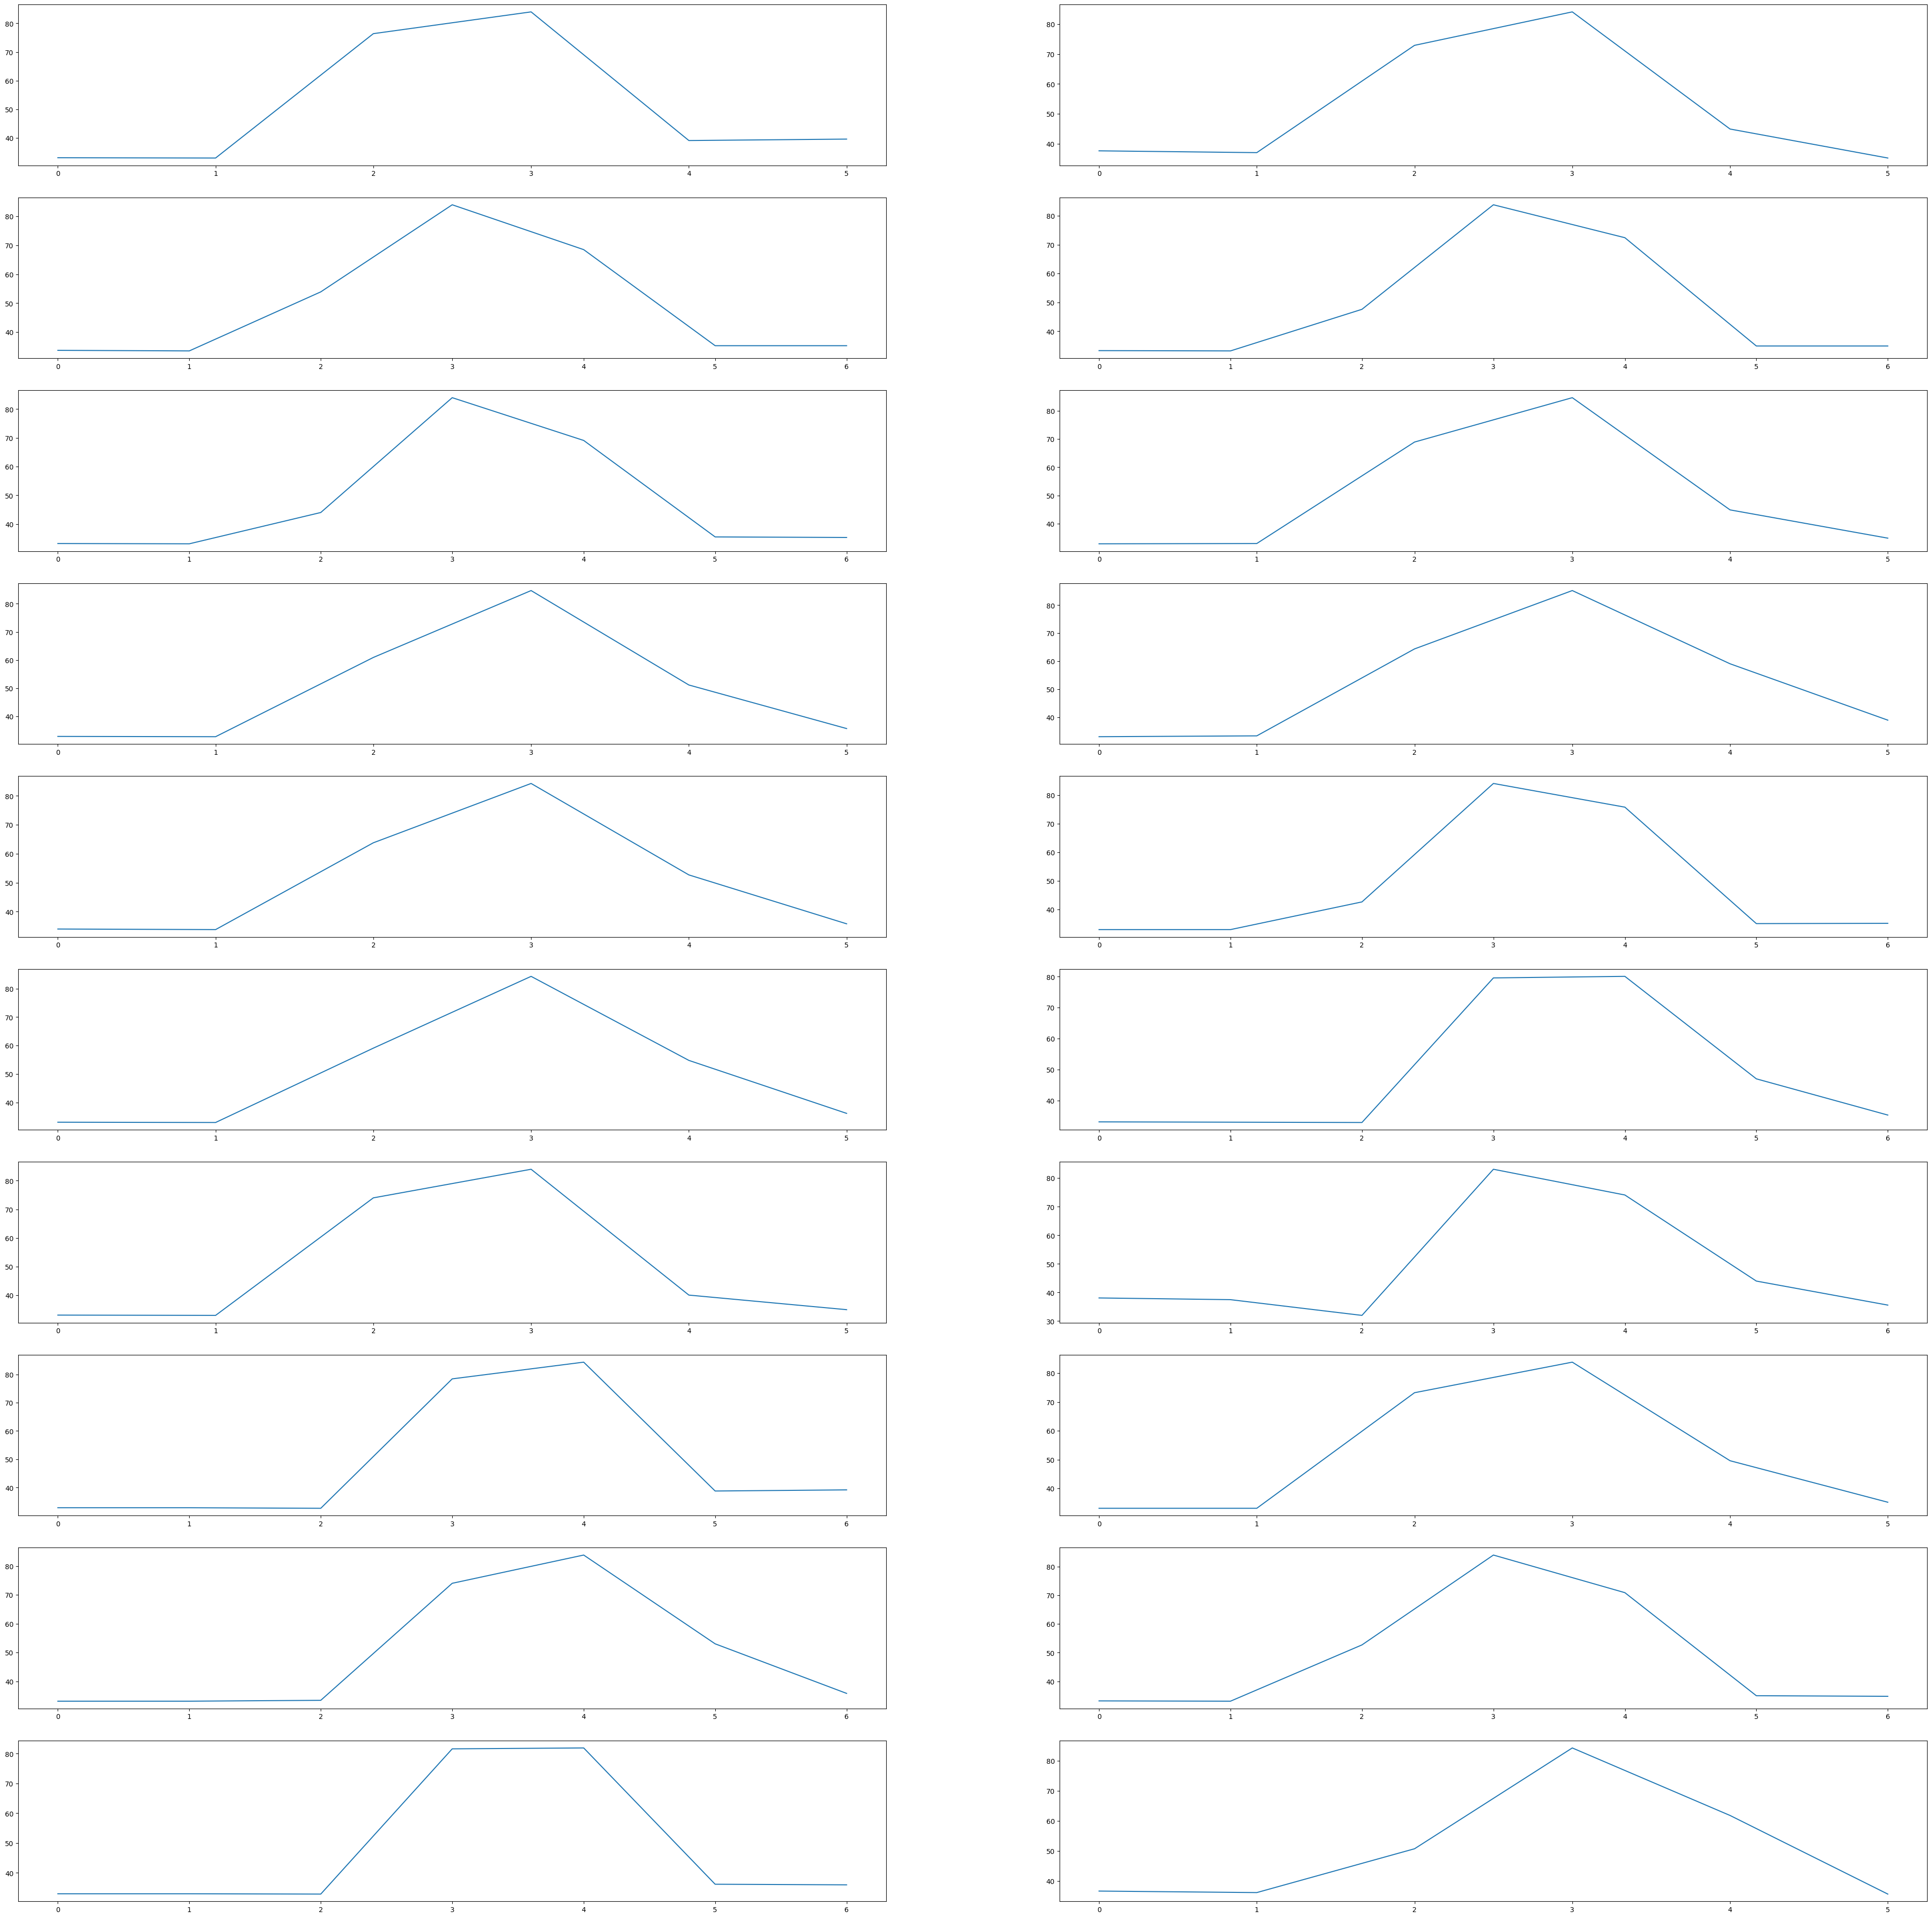

In [40]:
plot_dataframes(energy_tables, 10, 2)

### Performance Values

In [17]:
from helpers.stats import SystemStats
from helpers.stats import ContainerStats

In [18]:
def get_system_utilization(DIRS):
    rows = []
    for x in DIRS:
        f1, f2 = glob.glob(f"{x}/system_*.json")
        data = SystemStats(f2, f1).data[0]
        rows.append(
            {'cpu': data['cpu0'], 'disk': data['disk'], 'io': data['io'], 'duration': data['duration']}
        )

    return pd.DataFrame.from_records(rows)

### Server Performance

In [19]:
system_stats     = get_system_utilization(DIRS)
mean_duration    = system_stats['duration'].mean()
mean_disk        = system_stats['disk'].mean()
mean_io          = system_stats['io'].mean()
sys_mean_cpu     = system_stats['cpu'].mean()
arrival_rate     = CUST/mean_duration

In [20]:
print(
    "Server Stats\n",
    f"mean_cpu: {sys_mean_cpu:}",
    f"mean_disk: {mean_disk:}",
    f"mean_duration: {mean_duration:}",
    f"mean_io: {mean_io:}",
    f"arrival_rate: {arrival_rate:}",
    sep='\n'
)

Server Stats

mean_cpu: 33.37056666666667
mean_disk: 5.501166666666665
mean_duration: 7.031395840644836
mean_io: 153.23333333333332
arrival_rate: 10.666445425595878


### Throughput of each Run

In [21]:
# Read the JTL file
def get_jtl_single_run(path):
    d = pd.read_csv(f"{path}/requests.jtl")
    return d[d['label'] == 'BuyTicket']

def get_jtl_over_trial(paths):    
    return [get_jtl_single_run(x) for x in paths if len(get_jtl_single_run(x)) <= CUST]

def calculate_throughput(jtl):
    start = jtl.iloc[0].loc['timeStamp']
    last = jtl.iloc[-1]
    end = last.loc['timeStamp'] + last.loc['elapsed']
    
    print(
        f"requests: {len(jtl)}", 
        f"duration(s): {(end-start)/1000}"
    )
    
    return len(jtl)/((end-start)/1000)

In [22]:
jtls = get_jtl_over_trial(DIRS)

In [23]:
throughput = np.array([calculate_throughput(x) for x in jtls])
throughput.mean()

requests: 75 duration(s): 2.052
requests: 75 duration(s): 2.056
requests: 75 duration(s): 2.258
requests: 75 duration(s): 2.073
requests: 75 duration(s): 1.998
requests: 75 duration(s): 1.916
requests: 75 duration(s): 2.034
requests: 75 duration(s): 2.011
requests: 75 duration(s): 1.972
requests: 75 duration(s): 2.094
requests: 75 duration(s): 1.947
requests: 75 duration(s): 2.242
requests: 75 duration(s): 2.005
requests: 75 duration(s): 2.192
requests: 75 duration(s): 2.095
requests: 75 duration(s): 2.187
requests: 75 duration(s): 2.252
requests: 75 duration(s): 2.247
requests: 75 duration(s): 2.035
requests: 75 duration(s): 1.995
requests: 75 duration(s): 2.116
requests: 75 duration(s): 2.094
requests: 75 duration(s): 2.281
requests: 75 duration(s): 2.157
requests: 75 duration(s): 1.978
requests: 75 duration(s): 2.121
requests: 75 duration(s): 2.102
requests: 75 duration(s): 1.987
requests: 75 duration(s): 2.212
requests: 75 duration(s): 2.237


35.83294506670588

### Containers Utilization

In [24]:
def get_containers_stats_single_run(path):
    f1, f2 = glob.glob(f"{path}/containers_*.json")
    data = ContainerStats(f2, f1).data
    return {k: [v['cpu'], v['disk'], v['io']] for k,v in data.items()}

def get_containers_stats_over_trial(DIRS):
    return pd.DataFrame.from_records([get_containers_stats_single_run(x) for x in DIRS])

In [25]:
containers_stats = get_containers_stats_over_trial(DIRS)

In [26]:
utilization = pd.DataFrame(columns=['container', 'cpu', 'disk', 'io'])

In [27]:
utilization = pd.DataFrame([{
    'container': k, 
    'cpu'      : np.array([v[0] for v in containers_stats[k]]).mean(),
    'disk'     : np.array([v[1] for v in containers_stats[k]]).mean(),
    'io'       : np.array([v[2] for v in containers_stats[k]]).mean()
} for k in containers_stats.keys()])

In [28]:
utilization.sort_values(by=['cpu'])

,container,cpu,disk,io
19,baseline-ts-seat-service-1,0.015281,0.000000,0.000000
16,baseline-ts-train-service-1,0.016436,0.000000,0.000000
6,baseline-ts-user-service-1,0.016469,0.000000,0.000000
1,baseline-ts-price-service-1,0.016595,0.000000,0.000000
7,baseline-ts-config-service-1,0.016682,0.000000,0.000000
15,baseline-ts-consign-service-1,0.016734,0.000000,0.000000
0,baseline-ts-consign-price-service-1,0.102523,0.000000,0.066667
26,baseline-ts-price-mongo-1,0.103088,0.000000,0.266667
23,baseline-ts-inside-payment-mongo-1,0.103274,0.000000,0.000000
25,baseline-ts-payment-mongo-1,0.103299,0.000000,0.000000
